In [4]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import torch

print(f'{torch.cuda.is_available() = }')
print(f'{torch.cuda.device_count() = }')

torch.cuda.is_available() = False
torch.cuda.device_count() = 0


In [5]:
pip install ultralytics --user


Note: you may need to restart the kernel to use updated packages.


In [6]:
!pip install -U ipywidgets

In [7]:
dataset_path = 'Car_Plate'

In [8]:
import re

def the_number_in_the_string(filename):
    match = re.search(r'(\d+)', filename)
    
    if match:
        return int(match.group(0))
    else:
        return 0

In [9]:
print(the_number_in_the_string("file123.txt"))  
print(the_number_in_the_string("no_numbers"))

123
0


In [10]:
labels_dict = dict(
    img_path=[], 
    xmin=[], 
    xmax=[], 
    ymin=[], 
    ymax=[], 
    img_w=[], 
    img_h=[]
)

In [11]:
labels_dict

{'img_path': [],
 'xmin': [],
 'xmax': [],
 'ymin': [],
 'ymax': [],
 'img_w': [],
 'img_h': []}

In [13]:
import os
from glob import glob

xml_files = glob(f'{dataset_path}/annotations/*.xml')
xml_files

['Car_Plate/annotations\\Cars0.xml',
 'Car_Plate/annotations\\Cars1.xml',
 'Car_Plate/annotations\\Cars10.xml',
 'Car_Plate/annotations\\Cars100.xml',
 'Car_Plate/annotations\\Cars101.xml',
 'Car_Plate/annotations\\Cars102.xml',
 'Car_Plate/annotations\\Cars103.xml',
 'Car_Plate/annotations\\Cars104.xml',
 'Car_Plate/annotations\\Cars105.xml',
 'Car_Plate/annotations\\Cars106.xml',
 'Car_Plate/annotations\\Cars107.xml',
 'Car_Plate/annotations\\Cars108.xml',
 'Car_Plate/annotations\\Cars109.xml',
 'Car_Plate/annotations\\Cars11.xml',
 'Car_Plate/annotations\\Cars110.xml',
 'Car_Plate/annotations\\Cars111.xml',
 'Car_Plate/annotations\\Cars112.xml',
 'Car_Plate/annotations\\Cars113.xml',
 'Car_Plate/annotations\\Cars114.xml',
 'Car_Plate/annotations\\Cars115.xml',
 'Car_Plate/annotations\\Cars116.xml',
 'Car_Plate/annotations\\Cars117.xml',
 'Car_Plate/annotations\\Cars118.xml',
 'Car_Plate/annotations\\Cars119.xml',
 'Car_Plate/annotations\\Cars12.xml',
 'Car_Plate/annotations\\Cars120

In [15]:
import xml.etree.ElementTree as xet

In [16]:
import cv2

for filename in sorted(xml_files, key=the_number_in_the_string):
    
    info = xet.parse(filename)
    root = info.getroot()    
    
 # Finding BB info
    member_object = root.find('object')
    labels_info = member_object.find('bndbox')
    xmin = int(labels_info.find('xmin').text)
    xmax = int(labels_info.find('xmax').text)
    ymin = int(labels_info.find('ymin').text)
    ymax = int(labels_info.find('ymax').text)
    
# join full path
    img_name = root.find('filename').text
    img_path = os.path.join(dataset_path, 'images', img_name)
    
# add to dictionary
    labels_dict['img_path'].append(img_path)
    labels_dict['xmin'].append(xmin)
    labels_dict['xmax'].append(xmax)
    labels_dict['ymin'].append(ymin)
    labels_dict['ymax'].append(ymax)
    
# Read img and get dimensions
    height, width, _ = cv2.imread(img_path).shape
    labels_dict['img_w'].append(width)
    labels_dict['img_h'].append(height)
    
    alldata = pd.DataFrame(labels_dict)

In [17]:
alldata

,img_path,xmin,xmax,ymin,ymax,img_w,img_h
0,Car_Plate\images\Cars0.png,226,419,125,173,500,268
1,Car_Plate\images\Cars1.png,134,262,128,160,400,248
2,Car_Plate\images\Cars2.png,229,270,176,193,400,400
3,Car_Plate\images\Cars3.png,142,261,128,157,400,225
4,Car_Plate\images\Cars4.png,156,503,82,253,590,350
...,...,...,...,...,...,...,...
428,Car_Plate\images\Cars428.png,142,258,128,157,400,225
429,Car_Plate\images\Cars429.png,86,208,166,195,301,400
430,Car_Plate\images\Cars430.png,38,116,159,197,400,225
431,Car_Plate\images\Cars431.png,55,343,82,147,400,192


In [18]:
from sklearn.model_selection import train_test_split


train, test = train_test_split(alldata, test_size=1/10, random_state=42)
train, val = train_test_split(train, train_size=8/9, random_state=42)

print(f'''
      len(train) = {len(train)}
      len(val) = {len(val)}
      len(test) = {len(test)}
''')


      len(train) = 345
      len(val) = 44
      len(test) = 44



In [19]:
import shutil

if os.path.exists('datasets'):
    shutil.rmtree('datasets')

In [20]:
train

,img_path,xmin,xmax,ymin,ymax,img_w,img_h
124,Car_Plate\images\Cars124.png,305,320,256,267,400,267
315,Car_Plate\images\Cars315.png,12,385,98,181,400,300
282,Car_Plate\images\Cars282.png,37,319,145,203,350,263
236,Car_Plate\images\Cars236.png,223,250,106,119,400,176
112,Car_Plate\images\Cars112.png,49,164,135,191,240,400
...,...,...,...,...,...,...,...
110,Car_Plate\images\Cars110.png,286,328,133,159,400,267
255,Car_Plate\images\Cars255.png,116,273,156,188,400,267
292,Car_Plate\images\Cars292.png,91,137,187,208,400,267
54,Car_Plate\images\Cars54.png,148,257,61,118,400,300


# Creating data in YOLO format

In [21]:
def make_split_folder_in_yolo_format(split_name, split_df):
# folders in YOLO format
    labels_path = os.path.join('datasets', 'cars_license_plate_new', split_name, 'labels')
    images_path = os.path.join('datasets', 'cars_license_plate_new', split_name, 'images')

    
    os.makedirs(labels_path)
    os.makedirs(images_path)
    
    
    for _, row in split_df.iterrows():
        img_name, img_extension = os.path.splitext(os.path.basename(row['img_path']))
        
        
        x_center = (row['xmin'] + row['xmax']) / 2 / row['img_w']
        y_center = (row['ymin'] + row['ymax']) / 2 / row['img_h']
        width = (row['xmax'] - row['xmin']) / row['img_w']
        height = (row['ymax'] - row['ymin']) / row['img_h']

    # save lables in YOLO format
        label_path = os.path.join(labels_path, f'{img_name}.txt')
        with open(label_path, 'w') as file:
            file.write(f"0 {x_center:.4f} {y_center:.4f} {width:.4f} {height:.4f}\n")
            
        
        shutil.copy(row['img_path'], os.path.join(images_path, img_name + img_extension))
    
    print(f"Created '{images_path}' and '{labels_path}'")

In [22]:
make_split_folder_in_yolo_format("train", train)
make_split_folder_in_yolo_format("val", val)
make_split_folder_in_yolo_format("test", test)

Created 'datasets\cars_license_plate_new\train\images' and 'datasets\cars_license_plate_new\train\labels'
Created 'datasets\cars_license_plate_new\val\images' and 'datasets\cars_license_plate_new\val\labels'
Created 'datasets\cars_license_plate_new\test\images' and 'datasets\cars_license_plate_new\test\labels'


Object detection and bounding box

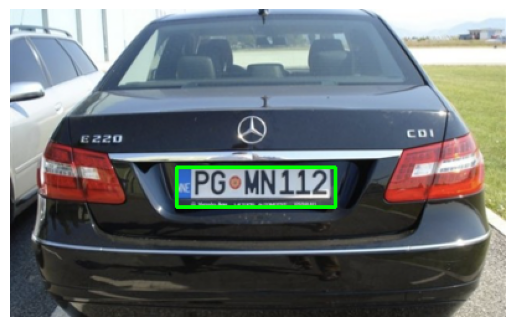

In [23]:
image_dir = 'datasets/cars_license_plate_new/train/images'
label_dir = 'datasets/cars_license_plate_new/train/labels'

image_files = sorted(os.listdir(image_dir))
first_image_file = image_files[0]

# Construct paths for image and its label
image_path = os.path.join(image_dir, first_image_file)
label_path = os.path.join(label_dir, os.path.splitext(first_image_file)[0] + '.txt')

image = cv2.imread(image_path)

# Convert img BGR to OpenCV
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


with open(label_path, 'r') as f:
    lines = f.readlines()


for line in lines:
    
    class_id, x_center, y_center, width, height = map(float, line.strip().split())
    img_height, img_width, _ = image.shape

# Convert YOLO format to bounding box format
    x_center *= img_width
    y_center *= img_height
    width *= img_width
    height *= img_height

    
    x1 = int(x_center - width / 2)
    y1 = int(y_center - height / 2)
    x2 = int(x_center + width / 2)
    y2 = int(y_center + height / 2)

    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)


plt.imshow(image)
plt.axis('off')  
plt.show()

In [24]:
datasets_yaml = '''
path: cars_license_plate_new

train: train/images
val: val/images
test: test/images

# number of classes
nc: 1

# class names
names: ['license_plate']
'''

with open('datasets.yaml', 'w') as file:
    file.write(datasets_yaml)

# Using YOLOv8 nano model

In [25]:
from ultralytics import YOLO
model = YOLO('yolov8n.pt')

In [26]:
os.environ['WANDB_MODE'] = 'offline'

In [27]:
model.train(
    data='datasets.yaml',  
    epochs=100,            
    batch=16,                 
    imgsz=320,  # Image size (width and height) for training           
    cache=True             
)

Ultralytics YOLOv8.2.98  Python-3.11.5 torch-2.4.1+cpu CPU (Intel Core(TM) i5-8350U 1.70GHz)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=datasets.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=320, save=True, save_period=-1, cache=True, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=

train: Scanning C:\Users\hp\Desktop\Python Practice\datasets\cars_license_plate_new\train\labels... 345 images, 0 backgrounds, 0 corrupt: 100%|██████████| 345/345 [00:00<00:00, 380.87it/s]


train: New cache created: C:\Users\hp\Desktop\Python Practice\datasets\cars_license_plate_new\train\labels.cache
WARNING  cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


train: Caching images (0.1GB RAM): 100%|██████████| 345/345 [00:00<00:00, 430.64it/s]
val: Scanning C:\Users\hp\Desktop\Python Practice\datasets\cars_license_plate_new\val\labels... 44 images, 0 backgrounds, 0 corrupt: 100%|██████████| 44/44 [00:00<00:00, 404.33it/s]

val: New cache created: C:\Users\hp\Desktop\Python Practice\datasets\cars_license_plate_new\val\labels.cache


WARNING  cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


val: Caching images (0.0GB RAM): 100%|██████████| 44/44 [00:00<00:00, 436.84it/s]


Plotting labels to runs\detect\train2\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 320 train, 320 val
Using 0 dataloader workers
Logging results to runs\detect\train2
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100         0G      1.613      2.786      1.251         18        320: 100%|██████████| 22/22 [00:41<00:00,  1.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.31s/it]

                   all         44         44    0.00368      0.955       0.42      0.168



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100         0G      1.511      1.517      1.115         14        320: 100%|██████████| 22/22 [00:42<00:00,  1.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.04it/s]

                   all         44         44    0.00433      0.955      0.203      0.123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100         0G      1.588      1.422      1.188         17        320: 100%|██████████| 22/22 [00:41<00:00,  1.87s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.13it/s]

                   all         44         44       0.54      0.182      0.233      0.102



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100         0G      1.538      1.365      1.175         21        320: 100%|██████████| 22/22 [00:39<00:00,  1.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.19it/s]

                   all         44         44      0.526      0.318      0.371      0.182



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100         0G      1.486      1.255      1.156         18        320: 100%|██████████| 22/22 [00:38<00:00,  1.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.05it/s]

                   all         44         44      0.534      0.651      0.636      0.286



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100         0G      1.504      1.188      1.137         20        320: 100%|██████████| 22/22 [00:38<00:00,  1.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.19it/s]

                   all         44         44      0.694      0.568      0.608       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100         0G      1.462      1.141      1.139         15        320: 100%|██████████| 22/22 [00:39<00:00,  1.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.20it/s]

                   all         44         44      0.518      0.611      0.461      0.226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100         0G      1.408      1.109      1.151         22        320: 100%|██████████| 22/22 [00:38<00:00,  1.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.12it/s]

                   all         44         44      0.714      0.568      0.631      0.292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100         0G      1.392      1.053      1.124         11        320: 100%|██████████| 22/22 [00:39<00:00,  1.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.17it/s]

                   all         44         44      0.822      0.795      0.793      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100         0G      1.434      1.056      1.117         20        320: 100%|██████████| 22/22 [00:39<00:00,  1.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.07it/s]

                   all         44         44       0.91       0.75      0.845       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100         0G      1.359     0.9731      1.103         26        320: 100%|██████████| 22/22 [00:39<00:00,  1.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.20it/s]

                   all         44         44      0.855      0.864      0.878      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100         0G      1.354     0.9369      1.068         24        320: 100%|██████████| 22/22 [00:39<00:00,  1.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.19it/s]

                   all         44         44      0.854      0.797      0.895      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100         0G      1.318     0.9173      1.081         22        320: 100%|██████████| 22/22 [00:38<00:00,  1.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.06it/s]

                   all         44         44      0.886      0.885      0.917      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100         0G      1.285     0.8886       1.06         18        320: 100%|██████████| 22/22 [00:39<00:00,  1.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.21it/s]

                   all         44         44       0.87       0.75       0.87      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100         0G      1.305     0.8716      1.083         14        320: 100%|██████████| 22/22 [00:39<00:00,  1.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.08it/s]

                   all         44         44      0.814      0.795      0.818      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100         0G      1.303     0.8811      1.089         12        320: 100%|██████████| 22/22 [00:39<00:00,  1.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.22it/s]

                   all         44         44      0.974      0.856      0.881      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100         0G      1.289     0.8545      1.061         13        320: 100%|██████████| 22/22 [00:39<00:00,  1.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.06it/s]

                   all         44         44      0.843      0.853      0.847      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100         0G      1.259     0.8484      1.057         15        320: 100%|██████████| 22/22 [00:38<00:00,  1.74s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.12it/s]

                   all         44         44      0.823      0.848       0.85      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100         0G      1.223      0.813      1.065         17        320: 100%|██████████| 22/22 [00:37<00:00,  1.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.27it/s]

                   all         44         44        0.8      0.816       0.82      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100         0G      1.238     0.7896      1.066         14        320: 100%|██████████| 22/22 [00:37<00:00,  1.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.11it/s]

                   all         44         44      0.822      0.864      0.825      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100         0G       1.24     0.7894      1.034         22        320: 100%|██████████| 22/22 [00:37<00:00,  1.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.26it/s]

                   all         44         44      0.834      0.932      0.925      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100         0G      1.196     0.7769      1.049         11        320: 100%|██████████| 22/22 [00:37<00:00,  1.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.11it/s]

                   all         44         44      0.881      0.843      0.908       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100         0G      1.284     0.7824      1.078         21        320: 100%|██████████| 22/22 [00:37<00:00,  1.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.27it/s]

                   all         44         44      0.961      0.795        0.9      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100         0G      1.166     0.7529      1.065         17        320: 100%|██████████| 22/22 [00:37<00:00,  1.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.11it/s]

                   all         44         44      0.863      0.863       0.89      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100         0G      1.207     0.7705      1.052         17        320: 100%|██████████| 22/22 [00:37<00:00,  1.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.26it/s]

                   all         44         44      0.838      0.864       0.88      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100         0G      1.193     0.7633      1.035         19        320: 100%|██████████| 22/22 [00:37<00:00,  1.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.13it/s]

                   all         44         44      0.796      0.909      0.879      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100         0G      1.119     0.7392      1.006         13        320: 100%|██████████| 22/22 [00:37<00:00,  1.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.26it/s]

                   all         44         44      0.832      0.864      0.848      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100         0G      1.152     0.7606      1.015         16        320: 100%|██████████| 22/22 [00:37<00:00,  1.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.12it/s]

                   all         44         44       0.88      0.886      0.899      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100         0G      1.116     0.7133     0.9989         23        320: 100%|██████████| 22/22 [00:37<00:00,  1.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.27it/s]

                   all         44         44      0.825      0.886      0.884       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100         0G      1.122     0.7348      1.017          9        320: 100%|██████████| 22/22 [00:37<00:00,  1.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.12it/s]

                   all         44         44      0.864      0.864      0.837      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100         0G      1.153     0.7359      1.015         18        320: 100%|██████████| 22/22 [00:37<00:00,  1.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.26it/s]

                   all         44         44      0.861      0.705      0.847      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100         0G      1.148      0.703      1.015         15        320: 100%|██████████| 22/22 [00:37<00:00,  1.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.12it/s]

                   all         44         44       0.85      0.905        0.9      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100         0G      1.081     0.6916       0.99         22        320: 100%|██████████| 22/22 [00:37<00:00,  1.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.27it/s]

                   all         44         44      0.923      0.819      0.919      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100         0G      1.053     0.6562     0.9869         17        320: 100%|██████████| 22/22 [00:37<00:00,  1.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.12it/s]

                   all         44         44      0.862      0.886      0.922      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100         0G      1.062     0.6852     0.9731         15        320: 100%|██████████| 22/22 [00:37<00:00,  1.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.28it/s]

                   all         44         44      0.871      0.818       0.89       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100         0G      1.081     0.6585     0.9845         11        320: 100%|██████████| 22/22 [00:38<00:00,  1.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.12it/s]

                   all         44         44      0.805      0.886      0.897      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100         0G      1.062     0.6744     0.9954         18        320: 100%|██████████| 22/22 [00:37<00:00,  1.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.27it/s]

                   all         44         44      0.912      0.841      0.915      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100         0G      1.051     0.6543     0.9876         16        320: 100%|██████████| 22/22 [00:39<00:00,  1.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.27it/s]

                   all         44         44       0.86      0.864       0.87       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100         0G       1.03     0.6462     0.9598         20        320: 100%|██████████| 22/22 [00:37<00:00,  1.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.27it/s]

                   all         44         44      0.844      0.886      0.874      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100         0G     0.9907     0.6335      0.981         17        320: 100%|██████████| 22/22 [00:38<00:00,  1.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.27it/s]

                   all         44         44      0.828      0.872      0.854      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100         0G      1.039     0.6372     0.9836         15        320: 100%|██████████| 22/22 [00:37<00:00,  1.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.27it/s]

                   all         44         44      0.939      0.841      0.907      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100         0G     0.9935     0.6068     0.9727         20        320: 100%|██████████| 22/22 [00:38<00:00,  1.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.27it/s]

                   all         44         44      0.854      0.841      0.862      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100         0G      1.014     0.6107     0.9804         15        320: 100%|██████████| 22/22 [00:37<00:00,  1.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.23it/s]

                   all         44         44      0.916      0.818      0.854      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100         0G      0.972     0.6038      0.964         17        320: 100%|██████████| 22/22 [00:37<00:00,  1.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.27it/s]

                   all         44         44      0.856      0.813      0.858      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100         0G      1.005     0.5997     0.9545         16        320: 100%|██████████| 22/22 [00:37<00:00,  1.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.17it/s]

                   all         44         44       0.86      0.864      0.866      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100         0G     0.9983     0.6068      0.971         21        320: 100%|██████████| 22/22 [00:37<00:00,  1.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.28it/s]

                   all         44         44      0.926      0.886      0.883      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100         0G      0.979      0.604     0.9692         14        320: 100%|██████████| 22/22 [00:37<00:00,  1.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.16it/s]

                   all         44         44      0.866      0.841      0.852      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100         0G     0.9965     0.6101     0.9625         16        320: 100%|██████████| 22/22 [00:37<00:00,  1.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.26it/s]

                   all         44         44      0.865      0.886       0.87      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100         0G     0.9308     0.5899     0.9532         22        320: 100%|██████████| 22/22 [00:37<00:00,  1.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.09it/s]

                   all         44         44      0.882      0.847       0.88       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100         0G     0.9821     0.5922     0.9596         14        320: 100%|██████████| 22/22 [00:37<00:00,  1.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.27it/s]

                   all         44         44        0.9      0.864      0.904      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100         0G     0.9832     0.5802     0.9568         14        320: 100%|██████████| 22/22 [00:37<00:00,  1.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.11it/s]

                   all         44         44       0.92      0.841      0.916      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100         0G      0.955     0.5638     0.9487         14        320: 100%|██████████| 22/22 [00:37<00:00,  1.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.27it/s]

                   all         44         44      0.902      0.839      0.895      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100         0G     0.9175     0.5655     0.9365         16        320: 100%|██████████| 22/22 [00:37<00:00,  1.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.11it/s]

                   all         44         44      0.864      0.886      0.907      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100         0G     0.9218     0.5522     0.9579         15        320: 100%|██████████| 22/22 [00:37<00:00,  1.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.26it/s]

                   all         44         44      0.859      0.886      0.905      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100         0G     0.9602     0.5784     0.9699         17        320: 100%|██████████| 22/22 [00:37<00:00,  1.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.10it/s]

                   all         44         44      0.855      0.841      0.911      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100         0G     0.9485     0.5625      0.951         17        320: 100%|██████████| 22/22 [00:37<00:00,  1.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.28it/s]

                   all         44         44      0.855      0.801      0.881      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100         0G     0.9441     0.5919     0.9598         22        320: 100%|██████████| 22/22 [00:37<00:00,  1.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.11it/s]

                   all         44         44      0.847      0.727      0.868       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100         0G     0.8744     0.5475     0.9283         18        320: 100%|██████████| 22/22 [00:37<00:00,  1.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.26it/s]

                   all         44         44      0.797      0.892      0.905      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100         0G     0.9042     0.5596     0.9336         15        320: 100%|██████████| 22/22 [00:37<00:00,  1.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.11it/s]

                   all         44         44      0.914      0.841      0.901      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100         0G      0.924     0.5518     0.9393         13        320: 100%|██████████| 22/22 [00:38<00:00,  1.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.10it/s]

                   all         44         44      0.866       0.88      0.882      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100         0G     0.9161     0.5562     0.9529         16        320: 100%|██████████| 22/22 [00:40<00:00,  1.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.27it/s]

                   all         44         44      0.846      0.841      0.888      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100         0G     0.8874     0.5267     0.9312         16        320: 100%|██████████| 22/22 [00:37<00:00,  1.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.26it/s]

                   all         44         44      0.885      0.878      0.908       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100         0G      0.888     0.5244     0.9208         17        320: 100%|██████████| 22/22 [00:38<00:00,  1.74s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.27it/s]

                   all         44         44      0.973      0.816      0.901      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100         0G     0.8768     0.5209     0.9377         13        320: 100%|██████████| 22/22 [00:37<00:00,  1.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.27it/s]

                   all         44         44      0.939      0.818      0.894      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100         0G     0.8764     0.5428     0.9409         16        320: 100%|██████████| 22/22 [00:37<00:00,  1.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.27it/s]

                   all         44         44      0.911      0.818      0.889      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100         0G     0.8656     0.5264     0.9314         16        320: 100%|██████████| 22/22 [00:37<00:00,  1.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.26it/s]

                   all         44         44      0.908      0.818      0.899      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100         0G     0.8378     0.5209     0.9271         13        320: 100%|██████████| 22/22 [00:38<00:00,  1.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.25it/s]

                   all         44         44      0.944      0.768       0.88       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100         0G     0.8522     0.5144     0.9176         16        320: 100%|██████████| 22/22 [00:37<00:00,  1.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.23it/s]

                   all         44         44      0.931      0.795      0.887       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100         0G     0.8471     0.5037     0.9333         15        320: 100%|██████████| 22/22 [00:37<00:00,  1.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.27it/s]

                   all         44         44      0.968      0.773      0.883      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100         0G     0.8571     0.5095     0.9265         13        320: 100%|██████████| 22/22 [00:37<00:00,  1.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.23it/s]

                   all         44         44       0.94      0.773      0.878      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100         0G     0.8368     0.5044     0.9326         15        320: 100%|██████████| 22/22 [00:37<00:00,  1.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.28it/s]

                   all         44         44      0.914      0.795      0.875      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100         0G     0.8383      0.504     0.9076         14        320: 100%|██████████| 22/22 [00:37<00:00,  1.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.20it/s]

                   all         44         44      0.928      0.773      0.889        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100         0G      0.866     0.5095     0.9431         15        320: 100%|██████████| 22/22 [00:37<00:00,  1.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.26it/s]

                   all         44         44      0.858      0.822        0.9      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100         0G     0.8022     0.4998     0.9033         13        320: 100%|██████████| 22/22 [00:37<00:00,  1.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.14it/s]

                   all         44         44      0.917      0.818       0.91       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100         0G     0.7952     0.4799     0.9098         16        320: 100%|██████████| 22/22 [00:37<00:00,  1.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.25it/s]

                   all         44         44      0.939      0.818      0.906      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100         0G     0.7916     0.4739     0.9115         11        320: 100%|██████████| 22/22 [00:37<00:00,  1.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.11it/s]

                   all         44         44      0.938      0.818      0.892      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100         0G     0.7746     0.4771     0.9113         22        320: 100%|██████████| 22/22 [00:37<00:00,  1.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.26it/s]

                   all         44         44      0.881      0.839      0.892      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100         0G     0.8089     0.4717     0.9179         13        320: 100%|██████████| 22/22 [00:37<00:00,  1.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.11it/s]

                   all         44         44      0.893      0.756      0.877      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100         0G     0.8296     0.4819     0.9221         14        320: 100%|██████████| 22/22 [00:37<00:00,  1.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.21it/s]

                   all         44         44      0.894      0.795      0.869      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100         0G     0.8021     0.4797     0.9227         14        320: 100%|██████████| 22/22 [00:37<00:00,  1.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.11it/s]

                   all         44         44      0.893      0.795      0.885      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100         0G      0.781     0.4629     0.9076         16        320: 100%|██████████| 22/22 [00:37<00:00,  1.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.27it/s]

                   all         44         44      0.892      0.795      0.885      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100         0G     0.7886     0.4717     0.9156         12        320: 100%|██████████| 22/22 [00:37<00:00,  1.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.13it/s]

                   all         44         44      0.755      0.932      0.906       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100         0G     0.7681     0.4552     0.9051         20        320: 100%|██████████| 22/22 [00:37<00:00,  1.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.20it/s]

                   all         44         44      0.943      0.773      0.891      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100         0G     0.7405     0.4629     0.9067         22        320: 100%|██████████| 22/22 [00:37<00:00,  1.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.12it/s]

                   all         44         44      0.835      0.818      0.885       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100         0G     0.7779      0.455     0.9062         15        320: 100%|██████████| 22/22 [00:37<00:00,  1.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.25it/s]

                   all         44         44      0.855      0.803      0.888       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100         0G     0.7923     0.4652     0.9271         17        320: 100%|██████████| 22/22 [00:37<00:00,  1.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.11it/s]

                   all         44         44      0.767      0.886      0.878      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100         0G     0.7735     0.4643     0.9155         14        320: 100%|██████████| 22/22 [00:39<00:00,  1.80s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.05it/s]

                   all         44         44      0.764      0.909      0.886      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100         0G     0.7303     0.4457     0.9081         14        320: 100%|██████████| 22/22 [00:39<00:00,  1.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.21it/s]

                   all         44         44      0.873      0.818      0.889      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100         0G     0.6996     0.4301     0.8849         16        320: 100%|██████████| 22/22 [00:39<00:00,  1.81s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.08it/s]

                   all         44         44      0.919      0.772       0.89      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100         0G     0.7556     0.4558     0.8984         16        320: 100%|██████████| 22/22 [00:38<00:00,  1.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.25it/s]

                   all         44         44      0.881      0.795      0.905      0.512


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100         0G     0.9888     0.5475     0.9971          9        320: 100%|██████████| 22/22 [00:37<00:00,  1.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.24it/s]

                   all         44         44      0.881      0.795      0.903       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100         0G      1.004      0.519     0.9984          9        320: 100%|██████████| 22/22 [00:36<00:00,  1.67s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.26it/s]

                   all         44         44      0.864      0.863      0.905      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100         0G     0.9782     0.5177     0.9815          9        320: 100%|██████████| 22/22 [00:37<00:00,  1.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.11it/s]

                   all         44         44      0.832        0.9      0.913       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100         0G     0.9377      0.496     0.9595          9        320: 100%|██████████| 22/22 [00:36<00:00,  1.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.27it/s]

                   all         44         44      0.859      0.831      0.891      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100         0G     0.9386      0.492     0.9777          9        320: 100%|██████████| 22/22 [00:37<00:00,  1.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.12it/s]

                   all         44         44      0.863      0.858      0.894      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100         0G     0.9514     0.4993     0.9758          9        320: 100%|██████████| 22/22 [00:36<00:00,  1.67s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.26it/s]

                   all         44         44       0.86      0.864      0.898      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100         0G     0.9271     0.4718     0.9615          9        320: 100%|██████████| 22/22 [00:36<00:00,  1.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.10it/s]

                   all         44         44      0.873      0.864      0.897      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100         0G     0.9147     0.4723     0.9649          9        320: 100%|██████████| 22/22 [00:36<00:00,  1.67s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.24it/s]

                   all         44         44      0.866      0.881      0.898       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100         0G     0.9053     0.4723     0.9613          9        320: 100%|██████████| 22/22 [00:36<00:00,  1.67s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.10it/s]

                   all         44         44      0.866      0.881      0.897      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100         0G      0.893     0.4687     0.9603          9        320: 100%|██████████| 22/22 [00:37<00:00,  1.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.27it/s]

                   all         44         44      0.866      0.878      0.897      0.532



100 epochs completed in 1.131 hours.
Optimizer stripped from runs\detect\train2\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train2\weights\best.pt, 6.2MB

Validating runs\detect\train2\weights\best.pt...
Ultralytics YOLOv8.2.98  Python-3.11.5 torch-2.4.1+cpu CPU (Intel Core(TM) i5-8350U 1.70GHz)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.44it/s]


                   all         44         44      0.866      0.881      0.897      0.535
Speed: 1.1ms preprocess, 25.8ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to runs\detect\train2


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000001431BBFF5D0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.0480

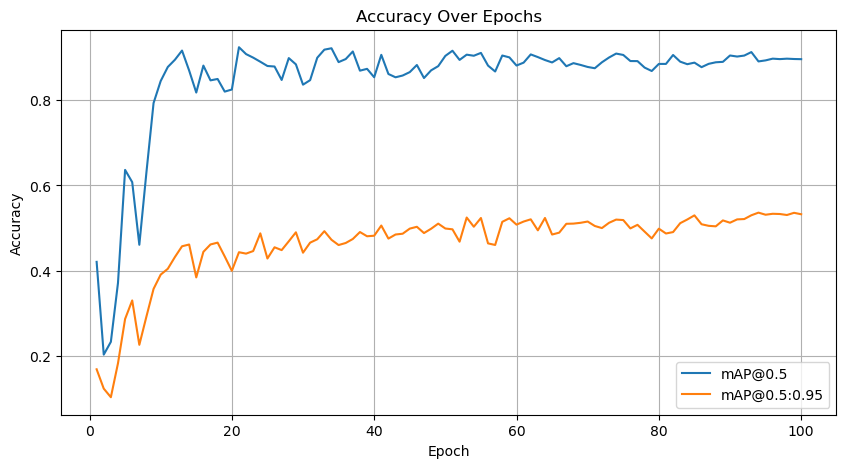

In [28]:
log_dir = max(glob('runs/detect/train*'), key=the_number_in_the_string)

results = pd.read_csv(os.path.join(log_dir, 'results.csv'))
results.columns = results.columns.str.strip()

epochs = results.index + 1 
mAP_0_5 = results['metrics/mAP50(B)'] 
mAP_0_5_0_95 = results['metrics/mAP50-95(B)']

plt.figure(figsize=(10, 5))
plt.plot(epochs, mAP_0_5, label='mAP@0.5')
plt.plot(epochs, mAP_0_5_0_95, label='mAP@0.5:0.95')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [29]:
model.save('license_plate_model_UTKARSH.pt')

# Test and predictions

In [1]:
def predict_and_plot(path_test_car):
   
    results = model.predict(path_test_car, device='cpu')

    
    image = cv2.imread(path_test_car)
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    
    for result in results:
        for box in result.boxes:
            
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            confidence = box.conf[0]

            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
            
            cv2.putText(image, f'{confidence*100:.2f}%', (x1, y1 - 10), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

    
    plt.imshow(image)
    plt.axis('off')  
    plt.show()


image 1/1 C:\Users\hp\Desktop\Python Practice\Car_Plate\images\Cars425.png: 160x320 1 license_plate, 52.6ms
Speed: 0.4ms preprocess, 52.6ms inference, 0.0ms postprocess per image at shape (1, 3, 160, 320)


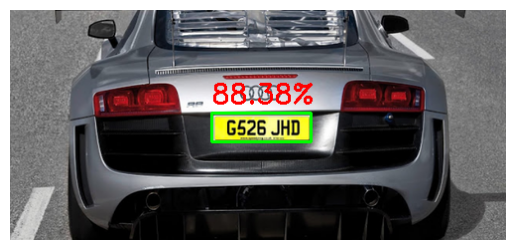

In [32]:
predict_and_plot(test.iloc[0].img_path)

# Text Extraction OCR

In [33]:
!pip3 install pytesseract

In [38]:
import pytesseract
from pytesseract import Output

In [39]:
def predict_and_plot(path_test_car):
    
    results = model.predict(path_test_car, device='cpu')

    image = cv2.imread(path_test_car)    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    
    for result in results:
        for box in result.boxes:
            
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            
            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
        # crop img
            roi = image[y1:y2, x1:x2]

        # Perform OCR on the cropped image
            text = pytesseract.image_to_string(roi, config='--psm 6')
            print(f"Detected text: {text}")

    
    plt.imshow(image)
    plt.axis('off') 
    plt.show()

In [37]:
predict_and_plot(test.iloc[0].img_path)


image 1/1 C:\Users\hp\Desktop\Python Practice\Car_Plate\images\Cars425.png: 160x320 1 license_plate, 43.9ms
Speed: 1.1ms preprocess, 43.9ms inference, 1.0ms postprocess per image at shape (1, 3, 160, 320)


TesseractNotFoundError: tesseract is not installed or it's not in your PATH. See README file for more information.